In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
import os
import nltk
import re
import torch
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch import nn
import matplotlib.pyplot as plt
import pickle

In [2]:
# Directories
cwd= os.getcwd()
data_dir= os.path.join(cwd, "../data/")
artifacts_dir= os.path.join(cwd, "../artifacts/")

In [3]:
df= pd.read_csv(data_dir + "IMDB-Dataset.csv")

In [4]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Text Preprocessing Utils
def clean_text(text):

    # Patterns to detect and replace
    urls= r'https?://\S+|www\.\S+'
    html_tags= r'<[^>]+>'
    # Punctuation Specific Patterns
    punct_repetition= r'(!|\?|\.){2,}'
    ellipsis= r'\.{3,}|\.\s*\.\s*\.|…'
    quotes= r'[“”]'
    apostrophes= r"[‘’]"
    hyphens= r'\b\d+-\d+\b'


    # Clean Text using Regex
    cleaned_text= text.lower()
    cleaned_text= re.sub(urls, ' ', cleaned_text)
    cleaned_text= re.sub(html_tags, ' ', cleaned_text)

    cleaned_text= re.sub(punct_repetition, r'\1', cleaned_text)
    cleaned_text= re.sub(ellipsis, '...', cleaned_text)
    cleaned_text= re.sub(quotes, r'"', cleaned_text)
    cleaned_text= re.sub(apostrophes, r"'", cleaned_text)
    cleaned_text= re.sub(hyphens, ' ', cleaned_text)
    
    # Removing Extra Spaces
    cleaned_text= re.sub(r'\s+', ' ', cleaned_text)
    cleaned_text= cleaned_text.strip()

    return cleaned_text

In [6]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/atlas/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
df['cleaned_review']= df['review'].apply(lambda x: clean_text(x))
df['cleaned_review'].head(5)

0    one of the other reviewers has mentioned that ...
1    a wonderful little production. the filming tec...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: cleaned_review, dtype: object

In [8]:
df['word_tokenized_review']= df['cleaned_review'].apply(lambda x: word_tokenize(x))
df['word_tokenized_review'].head(5)

0    [one, of, the, other, reviewers, has, mentione...
1    [a, wonderful, little, production, ., the, fil...
2    [i, thought, this, was, a, wonderful, way, to,...
3    [basically, there, 's, a, family, where, a, li...
4    [petter, mattei, 's, ``, love, in, the, time, ...
Name: word_tokenized_review, dtype: object

In [9]:
def build_vocab(tokenized_texts, min_freq= 1, special_tokens= None):

    if special_tokens is None:
        special_tokens= ['<PAD>', '<UNK>']
    
    word_freq= Counter()
    for text in tokenized_texts:
        word_freq.update(text)
    
    print(f"Total words in corpus: {sum(word_freq.values())}")
    print(f"Unique words before filtering: {len(word_freq)}")

    # First adding special tokens
    vocab= {}
    for idx, token in enumerate(special_tokens):
        vocab[token]= idx
    
    # Add all words that meet min_freq requirement
    current_idx= len(special_tokens)
    for word, freq in word_freq.most_common():
        if freq >= min_freq:
            vocab[word]= current_idx
            current_idx+= 1
        else:
            pass

    # Reverse vocab for decoding
    reverse_vocab= {idx: word for word, idx in vocab.items()}

    print(f"Final vocab size (including special tokens): {len(vocab)}")
    return vocab, reverse_vocab

In [10]:
X_train, X_test, Y_train, Y_test= train_test_split(df['word_tokenized_review'], df['sentiment'], test_size= 0.1, random_state= 42, stratify= df['sentiment'])

In [11]:
vocab_dict, reverse_vocab_dict= build_vocab(X_train)

Total words in corpus: 11871902
Unique words before filtering: 149904
Final vocab size (including special tokens): 149906


In [12]:
def encode_text(tokens, vocab):
    unk_id= vocab.get('<UNK>', 1)
    return [vocab.get(word, unk_id) for word in tokens]

def decode_text(ids, reverse_vocab):
    tokens= [reverse_vocab.get(i, '<ERR>') for i in ids]
    return ' '.join(tokens)


In [13]:
test_tokens = ['this', 'is', 'a', 'great', 'movie', 'unknownword']
encoded = encode_text(test_tokens, vocab_dict)
decoded = decode_text(encoded, reverse_vocab_dict)
print(f"\nTest Encoding:")
print(f"Original: {test_tokens}")
print(f"Encoded:  {encoded}")
print(f"Decoded:  '{decoded}'")


Test Encoding:
Original: ['this', 'is', 'a', 'great', 'movie', 'unknownword']
Encoded:  [13, 9, 6, 97, 20, 1]
Decoded:  'this is a great movie <UNK>'


In [14]:
df['encoded_texts']= df['word_tokenized_review'].apply(lambda x: encode_text(x, vocab_dict))
df.to_csv(data_dir+"preprocessed_imdb_dataset.csv")


In [15]:
class WordTokensDataset(Dataset):
    def __init__(self, encoded_texts, labels):
        self.encoded_texts= encoded_texts
        self.labels= labels

    def __len__(self):
        return len(self.encoded_texts)
    
    def __getitem__(self, idx):
        encoded_text= self.encoded_texts.iloc[idx]
        sentiment= 1 if self.labels.iloc[idx] == 'positive' else  0
        return  {
            'input_ids': torch.tensor(encoded_text, dtype= torch.long),
            'label': torch.tensor(sentiment, dtype= torch.long)
        }
        

In [16]:
X_train, X_test, Y_train, Y_test= train_test_split(df['encoded_texts'], df['sentiment'], test_size= 0.1, random_state= 42, stratify= df['sentiment'])

In [17]:
train_dataset= WordTokensDataset(X_train, Y_train)
val_dataset= WordTokensDataset(X_test, Y_test)

In [18]:
def custom_collate_fn(batch):
    # Separating input_ids and labels
    input_ids= [item['input_ids'] for item in batch]
    labels= [item['label'] for item in batch]
    
    # Padding sequences to the longest sequence in the batch
    padded_input_ids= pad_sequence(input_ids, batch_first= True, padding_value= 0)

    # Attention mask to ignore padding
    attention_mask= (padded_input_ids != 0).long()
    # Converting labels to tensor
    labels= torch.stack(labels)

    return {
        'input_ids': padded_input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

In [19]:
batch_size= 32
train_loader= DataLoader(train_dataset,
                         batch_size= batch_size,
                         shuffle= False,
                         collate_fn= custom_collate_fn)
val_loader= DataLoader(val_dataset,
                       batch_size= batch_size,
                       shuffle= False,
                       collate_fn= custom_collate_fn)
batch= next(iter(train_loader))
batch['input_ids'][1], batch['input_ids'].shape

(tensor([  456,    26,     2,   646,    40,   488, 36819,     4,     2,  4652,
             7, 16059,     9,    52,     2,   200,   491,     7,     6,  3263,
          2070,    42,  2280,    33,   246,  1643,  1430, 13078,   199,    18,
           124,   353,     3,     2,   342,     9,  5569,     4,     5,   200,
           540, 54349,    24,  2935,  3106,    23,     9,    37,     6, 18180,
             3,   337,  3247,     8,    33,   343,    15,  4005,     4,   540,
          2268,     8,   430,     6, 36820,     3,  2057,  2077,    18,  1337,
          1004,     8,   998,   318,  3535,  2701,   611,     4,     2,   230,
            22,   767,    45,     2,   176,    88,   633,   891,   786, 24034,
            16,   168,    53,  6043,  2127,    88,     9,  2753,  3091,  2701,
          2961,    40, 40713,   300,  1375,     7,    92,  2701,   119,    21,
         19902,    10,    18,   422,    45, 33854, 40714,     4, 14684,  2756,
             5,  1960,  6540,     3,    45,    44,  

In [20]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()

        self.embedding= nn.Embedding(vocab_size, embedding_dim)
        self.lstm= nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers= n_layers,
                           bidirectional= bidirectional,
                           dropout= dropout,
                           batch_first= True)
        self.fc= nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        self.dropout= nn.Dropout(dropout)
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm.weight' in name and len(param.size()) >= 2:
                    nn.init.orthogonal_(param)
                elif 'embedding.weight' in name:
                    nn.init.uniform_(param, -0.1, 0.1)
                elif 'fc.weight' in name:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
    
    def forward(self, text, text_lengths):
        embedded= self.dropout(self.embedding(text))

        packed_embedded= pack_padded_sequence(embedded, text_lengths.cpu(), batch_first= True, enforce_sorted= False)

        packed_output, (hidden, cell)= self.lstm(packed_embedded)

        if self.lstm.bidirectional:
            hidden= self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim= 1))
        else:
            hidden= self.dropout(hidden[-1, :, :])
        
        output= self.fc(hidden)
        
        return output

In [21]:
def train_model(model,
                train_loader,
                val_loader,
                optimizer,
                scheduler,
                criterion,
                device,
                n_epochs= 10):
    model.to(device)
    train_losses= []
    train_accuracies= []
    val_losses= []
    val_accuracies= []

    # Early Stopping
    best_val_accuracy= 0
    min_delta= 0.2
    patience= 3
    epochs_with_no_improvement= 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        all_predictions= []
        all_labels= []
        train_loss= 0
        for batch in train_loader:
            input_ids= batch['input_ids'].to(device)
            attention_mask= batch['attention_mask'].to(device)
            labels= batch['labels'].to(device)

            text_lengths= attention_mask.sum(dim=1)

            optimizer.zero_grad()

            predictions= model(input_ids, text_lengths).squeeze(1)

            loss= criterion(predictions, labels.float())

            loss.backward()
            optimizer.step()
            
            train_loss+= loss.item()
            binary_preds= torch.round(torch.sigmoid(predictions))
            binary_preds= binary_preds.detach()
            all_predictions.extend(binary_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        avg_train_loss= train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        accuracy= accuracy_score(all_labels, all_predictions)
        train_accuracies.append(accuracy)


        model.eval()
        val_loss= 0
        all_predictions= []
        all_labels= []

        with torch.no_grad():
            for batch in val_loader:
                input_ids= batch['input_ids'].to(device)
                attention_mask= batch['attention_mask'].to(device)
                labels= batch['labels'].to(device)

                text_lengths= attention_mask.sum(dim= 1)

                predictions= model(input_ids, text_lengths).squeeze(1)
                loss= criterion(predictions, labels.float())
                val_loss+= loss.item()

                binary_preds= torch.round(torch.sigmoid(predictions))
                binary_preds= binary_preds.detach()
                all_predictions.extend(binary_preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            avg_val_loss= val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            accuracy= accuracy_score(all_labels, all_predictions)
            val_accuracies.append(accuracy)
        
        scheduler.step(avg_val_loss)
        
        epochs= [e for e in range(1, epoch+1)]
        print(f"Epoch: {epoch}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {100 * train_accuracies[-1]:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {100 * val_accuracies[-1]:.2f}%")
        print("-"*30)
        
        if best_val_accuracy + min_delta < val_accuracies[-1]:
            best_val_accuracy= val_accuracies[-1]
            epochs_with_no_improvement= 0
        else:
            epochs_with_no_improvement+= 1
        if epochs_with_no_improvement >= patience:
            print(f"Early stopping triggerred during epoch {epoch}, No improvement in {patience} epochs")
            break

    print("="*80)
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'epochs': epochs
    }

In [22]:
torch.manual_seed(42)
VOCAB_SIZE= len(vocab_dict)
EMBEDDING_DIM= 128
HIDDEN_DIM= 256
OUTPUT_DIM= 1
N_LAYERS= 2
BIDIRECTIONAL= True
DROPOUT= 0.3
LEARNING_RATE= 0.001
model= LSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)
optimizer= torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'min', factor= 0.1, patience= 3)
criterion= nn.BCEWithLogitsLoss()
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history= train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, device)

Epoch: 1
Train Loss: 0.5618, Train Accuracy: 70.48%
Val Loss: 0.4380, Val Accuracy: 80.16%
------------------------------
Epoch: 2
Train Loss: 0.2936, Train Accuracy: 87.97%
Val Loss: 0.2507, Val Accuracy: 90.08%
------------------------------
Epoch: 3
Train Loss: 0.1564, Train Accuracy: 94.24%
Val Loss: 0.2578, Val Accuracy: 89.76%
------------------------------
Epoch: 4
Train Loss: 0.0989, Train Accuracy: 96.66%
Val Loss: 0.2896, Val Accuracy: 90.18%
------------------------------
Early stopping triggerred during epoch 4, No improvement in 3 epochs


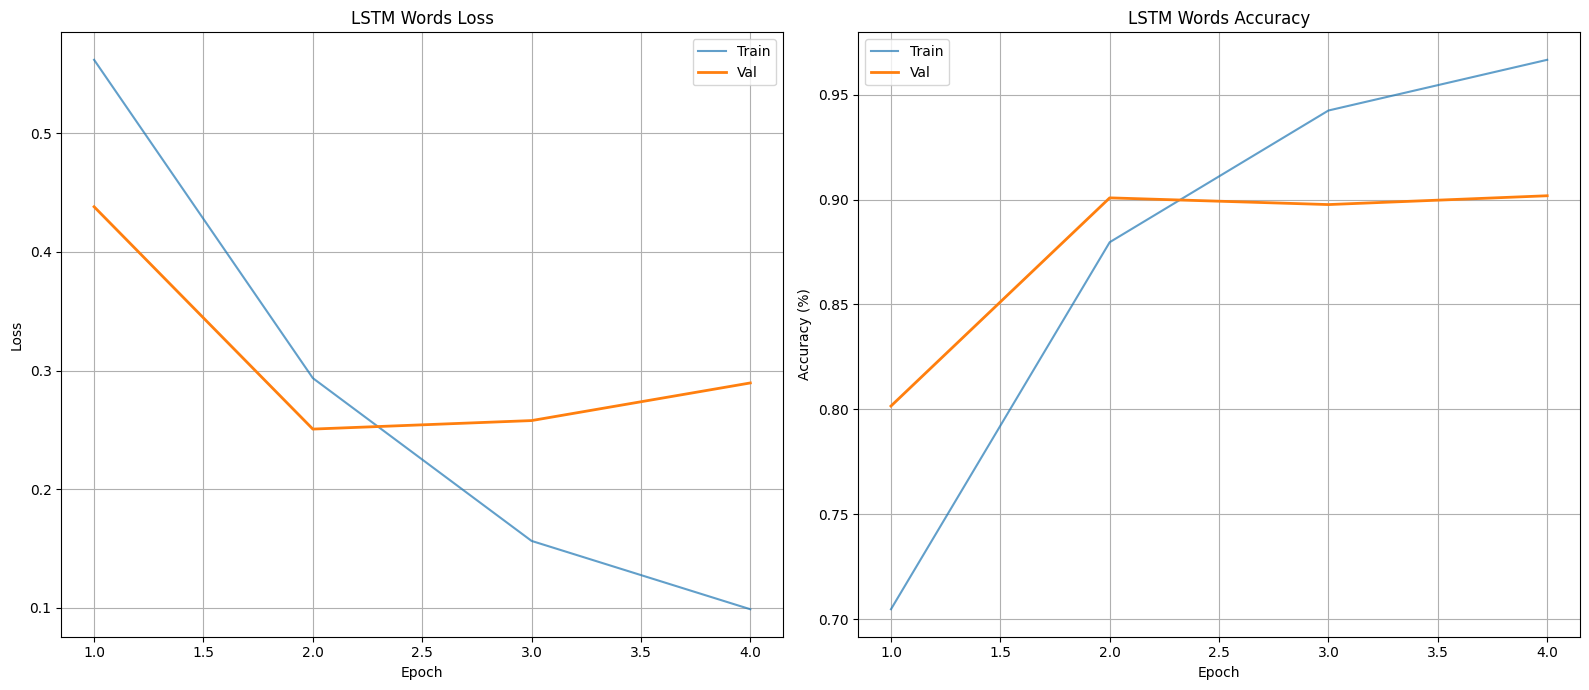

In [23]:
fig, axes= plt.subplots(1, 2, figsize= (16, 7))

axes[0].plot(history['epochs'], history['train_losses'], label= 'Train', alpha= 0.7)
axes[0].plot(history['epochs'], history['val_losses'], label= 'Val', linewidth= 2)
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LSTM Words Loss')
axes[0].legend()

axes[1].plot(history['epochs'], history['train_accuracies'], label= 'Train', alpha= 0.7)
axes[1].plot(history['epochs'], history['val_accuracies'], label= 'Val', linewidth= 2)
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('LSTM Words Accuracy')
axes[1].legend()


plt.tight_layout()
plt.show()

In [24]:
torch.save(model.state_dict(), artifacts_dir+"LSTM_Words_2layers_0.1val.pth")

In [25]:
with open(artifacts_dir+'vocab_dict.pkl', 'wb') as f:
    pickle.dump(vocab_dict, f)
    

In [26]:
def predict_sentiment(review_text, model, vocab, device, max_length= 512):
   
    cleaned_text= clean_text(review_text)

    tokens= word_tokenize(cleaned_text)

    encoded= encode_text(tokens, vocab)

    if len(encoded) > max_length:
        encoded= encoded[:max_length]
    
    input_tensor= torch.tensor(encoded, dtype= torch.long).unsqueeze(0).to(device)

    text_length= torch.tensor([len(encoded)], dtype= torch.long).to(device)

    model.eval()

    with torch.no_grad():
        output= model(input_tensor, text_length)
        probability= torch.sigmoid(output).item()
        prediction= 1 if probability > 0.5 else 0
    return prediction, probability

In [27]:
review= """Just a sweet movie, 

which is lovely, with beautiful decors. Doesnt deserve the hate it received.

Loved the animals and the songs. Gal Gadot is not great as queen. Rachel Zegler is good as always.

The dwarfs are funny, with good jokes and lots of gimmicks. The 'prince' is a bit too goofy.

His mixed band of merry men does not add much. The end scene was nice, could have been a bit longer. 

All together I really enjoyed it and can recommend it to many audiences of all ages. 

Go Watch out in the cinema, where the beautiful backgrounds will be extra great. A modern fairytale. 

The makers should be proud and ignore the haters."""

pred, prob= predict_sentiment(review, model, vocab_dict, device)

sentiment= 'positive' if pred == 1 else 'negative'

print(f"Review Text: {review}")
print('-'*50)
print(f"Predicted Sentiment: {sentiment}")

Review Text: Just a sweet movie, 

which is lovely, with beautiful decors. Doesnt deserve the hate it received.

Loved the animals and the songs. Gal Gadot is not great as queen. Rachel Zegler is good as always.

The dwarfs are funny, with good jokes and lots of gimmicks. The 'prince' is a bit too goofy.

His mixed band of merry men does not add much. The end scene was nice, could have been a bit longer. 

All together I really enjoyed it and can recommend it to many audiences of all ages. 

Go Watch out in the cinema, where the beautiful backgrounds will be extra great. A modern fairytale. 

The makers should be proud and ignore the haters.
--------------------------------------------------
Predicted Sentiment: positive
